# Diagnostics of FOCI-OpenIFS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:44185 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 64.00 GB


# Read NEMO grid

In [5]:
ds_mesh = xr.open_dataset('/data/user/jkjellsson/orca05_mesh_mask.nc')
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Read data

In [6]:
exp_list = ['focioifs-merge14']

In [7]:
# OpenIFS surface
ds_sfc_all = []
for exp in exp_list:
    sfc = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_sfc.nc' % (exp,)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords').rename({'time_counter':'time'})
    ds_sfc_all.append(ds_sfc)

In [8]:
# OpenIFS pressure levels
ds_pl_all = []
for exp in exp_list:
    pl = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/oifs/*1m*regular_pl.nc' % (exp,)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords').rename({'time_counter':'time'})
    ds_pl_all.append(ds_pl)

In [ ]:
# NEMO grid T
ds_t_all = []
for exp in exp_list:
    t = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/nemo/*1m*grid_T.nc' % (exp,)
    ds_t = xr.open_mfdataset(t,combine='by_coords').rename({'time_counter':'time'})
    ds_t_all.append(ds_t)

In [ ]:
# NEMO ice
ds_i_all = []
for exp in exp_list:
    ice = '/data/user/jkjellsson/esm-experiments/focioifs/%s/outdata/nemo/*1m*icemod.nc' % (exp,)
    ds_i = xr.open_mfdataset(ice,combine='by_coords').rename({'time_counter':'time'})
    ds_i_all.append(ds_i)

# Mean variables

In [ ]:
# Fluxes need to be scaled 
# They are stored in e.g. W/m2 * s
# So we divide by the frequency of XIOS call (usually 3hr for T95)
# For long climate runs we may use 24hr
flux_scale = 1./(24 * 60 * 60)

# Scale precip from m/s to mm/d
pr_scale = 1000. * 86400. * flux_scale

fig1, ax1 = plt.subplots(7,1,figsize=(6,12))

for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    ds_pl = ds_pl_all[i]
    exp = exp_list[i]
    
    # Read 2m temp
    t2m = ds_sfc['2t']
    # 500 hpa temp
    t500 = ds_pl['t'].sel(pressure_levels=50000)
    # Precip
    pr = ds_sfc['tp'] * pr_scale
    # Cloud cover
    tcc = ds_sfc['tcc'] * 100
    # TOA SW
    tsr = ds_sfc['tsr'] * flux_scale
    # TOA LW
    ttr = ds_sfc['ttr'] * flux_scale
    
    # Weighted global mean
    weights = np.cos(np.deg2rad(t2m.lat))
    weights.name = "weights"
    
    t2m_wgt = t2m.weighted(weights)
    t2m_mean = t2m_wgt.mean(('lon','lat'))
    
    t500_wgt = t500.weighted(weights)
    t500_mean = t500_wgt.mean(('lon','lat'))
    
    pr_wgt = pr.weighted(weights)
    pr_mean = pr_wgt.mean(('lon','lat'))
    
    tcc_wgt = tcc.weighted(weights)
    tcc_mean = tcc_wgt.mean(('lon','lat'))
    
    tsr_wgt = tsr.weighted(weights)
    tsr_mean = tsr_wgt.mean(('lon','lat'))
    
    ttr_wgt = ttr.weighted(weights)
    ttr_mean = ttr_wgt.mean(('lon','lat'))
    
    # Net TOA
    toa = tsr + ttr
    print(toa)
    
    # Annual mean
    t2m = t2m_mean.groupby('time.year').mean('time')
    t2m.plot(ax=ax1[0],alpha=1,label=exp)
    
    t500 = t500_mean.groupby('time.year').mean('time')
    t500.plot(ax=ax1[1],alpha=1)
    
    pr = pr_mean.groupby('time.year').mean('time')
    pr.plot(ax=ax1[2],alpha=1)
    
    tcc = tcc_mean.groupby('time.year').mean('time')
    tcc.plot(ax=ax1[3],alpha=1)
    
    tsr = tsr_mean.groupby('time.year').mean('time')
    tsr.plot(ax=ax1[4],alpha=1)
    
    ttr = ttr_mean.groupby('time.year').mean('time')
    ttr.plot(ax=ax1[5],alpha=1)
    
    toa = toa_mean.groupby('time.year').mean('time')
    toa.plot(ax=ax1[6],alpha=1)
    
for ax in [ax1]:
    ax[0].legend()
    ax[0].set_ylabel('Surf. temp. [K]')
    ax[1].set_ylabel('500 hPa temp. [K]')
    ax[2].set_ylabel('Precip. [mm/d]')
    ax[3].set_ylabel('Cloud cover [pct]')
    ax[4].set_ylabel('TOA SW [W/m2]')
    ax[5].set_ylabel('TOA LW [W/m2]')
    ax[6].set_ylabel('TOA net [W/m2]')

for ax in ax1:
    ax.set_title('')
    #ax.axis["right"].set_visible(False)
    
for ax in ax1[:-1]:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    #ax.axis["bottom"].set_visible(False)
    #ax.axis["top"].set_visible(False)

#ax1[-1].axis["top"].set_visible(False)
    
#fig1.tight_layout()
fig1.subplots_adjust(hspace=0.0) #, right=0.8, top=0.9)

fig1.savefig('global_means_oifs.pdf',format='pdf')

## Deep convection

In [ ]:
fig1, axs1 = plt.subplots(2,2,figsize=(16,8))
fig2, axs2 = plt.subplots(1,2,figsize=(8,5))

for i in range(0,len(exp_list)):
    ds_t = ds_t_all[i]
    exp = exp_list[i]
    mld = ds_t['somxl010']
    
    mld_s = mld.groupby('time.month').mean('time')
    print(mld_s)
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[0,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[0,1])
    
    mld_s = mld.groupby('time.month').max('time')
    print(mld_s)
    mld_s.sel(month=2).plot.pcolormesh(ax=axs1[1,0])
    mld_s.sel(month=9).plot.pcolormesh(ax=axs1[1,1])
    
    # Convective volume
    mld_mask = mld.where(mld > 800)
    # North Atlantic
    mld_natl = mld_mask.sel(x=slice(450,550),y=slice(350,450)) * da_orca05_area.sel(x=slice(450,550),y=slice(350,450))
    mld_natl_vol = mld_natl.sum(('x','y')) * 1e-12
    mld_natl_vol.plot(ax=axs2[0])
    # Weddell Sea
    mld_wed = mld_mask.sel(x=slice(480,600),y=slice(50,150)) * da_orca05_area.sel(x=slice(480,600),y=slice(50,150))
    mld_wed_vol = mld_wed.sum(('x','y')) * 1e-12
    mld_wed_vol.plot(ax=axs2[1])
    
    axs2[0].set_title('Convective volume (>800m) North Atlantic')
    axs2[1].set_title('Convective volume (>800m) Weddell Sea')
    for ax in axs2:
        ax.set_ylabel('Deep convective volume (1000 km3)')

fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('mld_mean_max.png',format='png',dpi=150)
fig2.savefig('deep_conv_vol.pdf',format='pdf')

## Sea ice

/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


<xarray.DataArray 'ileadfra' (month: 12, y: 511, x: 722)>
dask.array<stack, shape=(12, 511, 722), dtype=float32, chunksize=(1, 511, 722), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(511, 722), meta=np.ndarray>
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x


/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/common.py:672: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


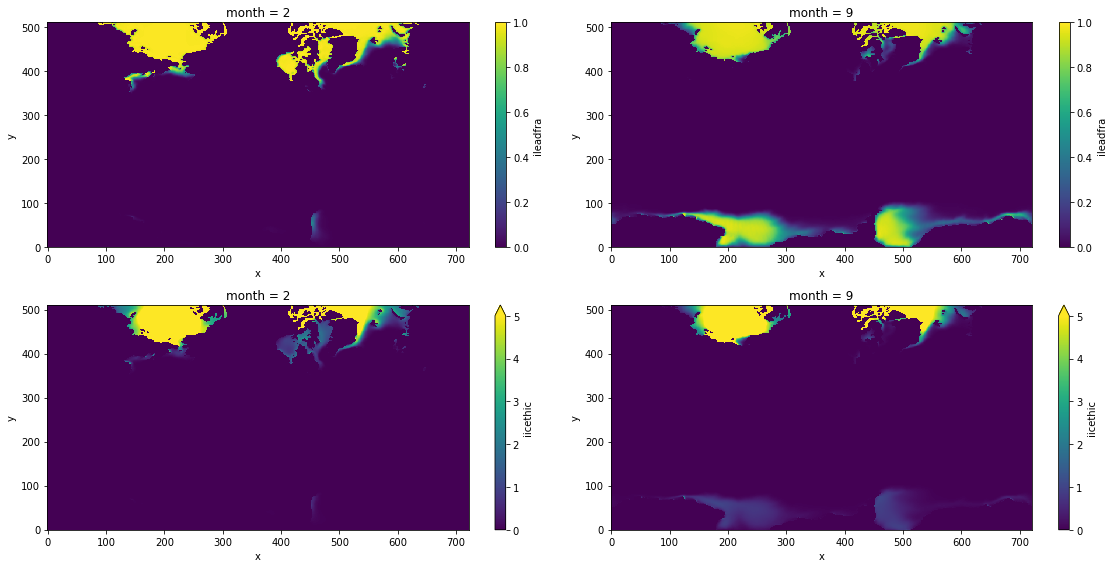

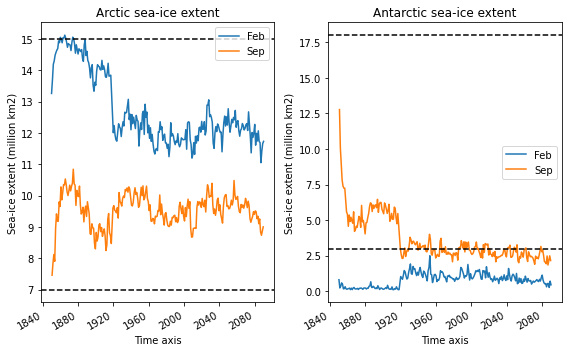

In [18]:
fig1, axs1 = plt.subplots(2,2,figsize=(16,8))
fig2, axs2 = plt.subplots(1,2,figsize=(8,5))

for i in range(0,len(exp_list)):
    ds_i = ds_i_all[i]
    exp = exp_list[i]
    icefrac = ds_i['ileadfra']
    icethk  = ds_i['iicethic']
    
    z = icefrac.groupby('time.month').mean('time')
    print(z)
    z.sel(month=2).plot.pcolormesh(ax=axs1[0,0],vmin=0,vmax=1)
    z.sel(month=9).plot.pcolormesh(ax=axs1[0,1],vmin=0,vmax=1)
    
    z = icethk.groupby('time.month').mean('time')
    z.sel(month=2).plot.pcolormesh(ax=axs1[1,0],vmin=0,vmax=5)
    z.sel(month=9).plot.pcolormesh(ax=axs1[1,1],vmin=0,vmax=5)
    
    # Sea ice extent (where ice > 15 pcnt)
    ice_mask = icefrac.where(icefrac > 0.15)
    # North 
    ice_nh = ice_mask.sel(y=slice(250,511)) * da_orca05_area.sel(y=slice(250,511))
    ice_nh_area = ice_nh.sum(('x','y')) * 1e-12
    ice_nh_area[1::12].plot(ax=axs2[0],label='Feb')
    ice_nh_area[8::12].plot(ax=axs2[0],label='Sep')
    # South
    ice_sh = ice_mask.sel(y=slice(0,250)) * da_orca05_area.sel(y=slice(0,250))
    ice_sh_area = ice_sh.sum(('x','y')) * 1e-12
    ice_sh_area[1::12].plot(ax=axs2[1],label='Feb')
    ice_sh_area[8::12].plot(ax=axs2[1],label='Sep')
    
    axs2[0].set_title('Arctic sea-ice extent')
    axs2[1].set_title('Antarctic sea-ice extent')
    
    axs2[0].axhline(y=7,linestyle='--',c='k')
    axs2[0].axhline(y=15,linestyle='--',c='k')
    axs2[1].axhline(y=3,linestyle='--',c='k')
    axs2[1].axhline(y=18,linestyle='--',c='k')
    
    for ax in axs2:
        ax.set_ylabel('Sea-ice extent (million km2)')
        ax.legend()

fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('ice_mean.png',format='png',dpi=150)
fig2.savefig('ice_extent.pdf',format='pdf')

# Radiative budget

In [ ]:
fscale = 1./(3 * 60 * 60.)

fig, ax = plt.subplots(4,1,figsize=(8,12))

for i in range(0,len(exp_list)):
    ds_sfc = ds_sfc_all[i]
    exp = exp_list[i]
    
    # Net TOA
    toa = (ds_sfc['tsr'] + ds_sfc['ttr']) * fscale
    print(toa)
    # Net turb sfc 
    thf = (ds_sfc['sshf'] + ds_sfc['slhf']) * fscale
    # Net sfc rad
    sfc = (ds_sfc['ssr'] + ds_sfc['str']) * fscale
    # Net atm (pos when warming)
    net = toa - thf - sfc 
    
    # Weighted global mean
    weights = np.cos(np.deg2rad(toa.lat))
    weights.name = "weights"
    
    toa_wgt = toa.weighted(weights)
    toa_mean = toa_wgt.mean(('lon','lat'))
    
    thf_wgt = thf.weighted(weights)
    thf_mean = thf_wgt.mean(('lon','lat'))
    
    sfc_wgt = sfc.weighted(weights)
    sfc_mean = sfc_wgt.mean(('lon','lat'))
    
    net_wgt = net.weighted(weights)
    net_mean = net_wgt.mean(('lon','lat'))
    
    # Annual mean
    toa = toa_mean.groupby('time.year').mean('time')
    toa.plot(ax=ax[0],alpha=1)
    
    thf = thf_mean.groupby('time.year').mean('time')
    thf.plot(ax=ax[1],alpha=1)
    
    sfc = sfc_mean.groupby('time.year').mean('time')
    (sfc+thf).plot(ax=ax[2],alpha=1)
    
    net = net_mean.groupby('time.year').mean('time')
    net.plot(ax=ax[3],alpha=1)
    
ax[0].legend()
ax[0].set_ylabel('Net TOA rad [W/m2]')
ax[1].set_ylabel('Net sfc THF [W/m2]')
ax[2].set_ylabel('Net sfc net [W/m2]')
ax[3].set_ylabel('Net atm [W/m2]')
fig.tight_layout()
fig.savefig('radiation_equilibration.pdf',format='pdf')

## ENSO

<xarray.DataArray 'sstk' (lat: 96, lon: 192)>
dask.array<sub, shape=(96, 192), dtype=float32, chunksize=(96, 192), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.9375 2.8125 4.6875 ... 355.3125 357.1875 359.0625
  * lat      (lat) float32 -89.0625 -87.1875 -85.3125 ... 87.1875 89.0625


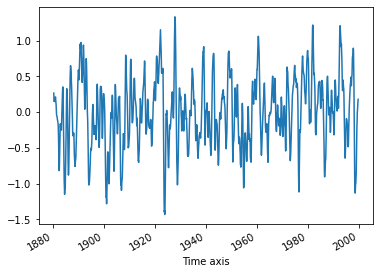

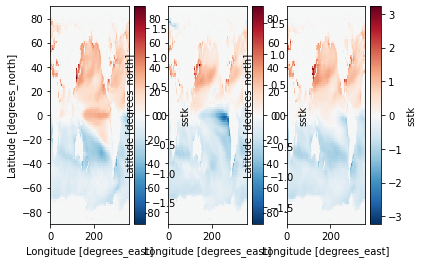